In [1]:
import pandas as pd

### sets up static data for different biased model tests

In [ ]:
COLUMNS = [
    'Model Prediction', 
    'Binary Outcome', 
    'Model Label', 
    'Sample Weight', # we ignore this because determining bias on weights may be misconstrued with actual health predispositions 
    'Demo Gender',
    'Demo Ethnicity'
]
GENDER = ['male', 'female']
ETHNICITY = ['white', 'hispanic', 'black', 'asian', 'other']
ETHNICITY_DIST = [50, 20, 20, 9, 1]
# makes ethnicity array with ETHNICITY for each number in ETHNICITY_DIST
ETHNICITY_ARRAY = [ethnicity for ethnicity, count in zip(ETHNICITY, ETHNICITY_DIST) for i in range(count)]

LABELS = ['Label-' + str(i) for i in range (0,100)]
total_combinations = len(LABELS) * len(GENDER) * len(ETHNICITY_ARRAY)

# makes combinations of GENDER, ETHNICITY, and LABELS
def makeCombinations():
    combinations = []
    for ethnicity in ETHNICITY_ARRAY:
        for label in LABELS:
            for gender in GENDER:
                sample_weight = 1
                combinations.append([label, sample_weight, gender, ethnicity])
    return combinations

combinations_array = makeCombinations()
# transform combinations_array into dataframe
combinations_df = pd.DataFrame(combinations_array, columns=COLUMNS[2:])

### Create test dataframes
These are used to demonstrate the disparity measurement under different circumstances where the model has `rand` predictions for all patients, `excel` preditions against the broad population, `poor` predicitions across the broad population, `low_pop` which has a limited number of hispanic females represented and performs excelently across the broad population, and finally `bias` where it performs poorly for the hispanic female population.

In [3]:
import random

# Makes a data frame with gender, ethnicity, and labels
def makeDataFrame(predictions):
    df = pd.DataFrame()
    df['Model Prediction'] = predictions
    # add column to dataframe where the binary outcome is 1 if the model prediction is greater than 0.5
    df['Binary Outcome'] = df['Model Prediction'].apply(lambda x: 1 if x > 0.5 else 0)
    # add all columns of the combinations_df to dataframe df
    df = pd.concat([df, combinations_df], axis=1)
    return df

# create random outcome predictions poor/neutral/excel
pred_poor = [random.randrange(0,70) / 100. for i in range(total_combinations)]
df_poor = makeDataFrame(pred_poor)

pred_rand = [random.random() for i in range(total_combinations)]
df_rand = makeDataFrame(pred_rand)

pred_excel = [random.randrange(30,100) / 100. for i in range(total_combinations)]
df_excel = makeDataFrame(pred_excel)


df_bias = makeDataFrame(pred_excel)
female = df_bias.loc[(df_bias['Demo Gender'] == 'female')]
for row in female.index:
    df_bias.loc[row,"Model Prediction"] = random.randrange(0,90)/100.

hisp_female = df_bias.loc[(df_bias['Demo Ethnicity'] == 'hispanic') & (df_bias['Demo Gender'] == 'female')]
for row in hisp_female.index:
    df_bias.loc[row,"Model Prediction"] = random.randrange(0,70)/100.

asian_female = df_bias.loc[(df_bias['Demo Ethnicity'] == 'asian') & (df_bias['Demo Gender'] == 'female')]
for row in asian_female.index:
    df_bias.loc[row,"Model Prediction"] = random.randrange(30,100)/100.

df_bias['Binary Outcome'] = df_bias['Model Prediction'].apply(lambda x: 1 if x > 0.5 else 0)
#TODO: low_pop

# write dataframes to file in folder sample_data from current path
df_poor.to_csv('./sample_data/measure_disparity_input_poor.csv', index=False)
df_excel.to_csv('./sample_data/measure_disparity_input_excel.csv', index=False)
df_rand.to_csv('./sample_data/measure_disparity_input_rand.csv', index=False)
df_bias.to_csv('./sample_data/measure_disparity_input_bias.csv', index=False)

we can see that without knowing the true population the bias disparity measurement performs similar to the t is also excellent even though the model is less likely to perform well on the underrepresented population (in this case hispanic females)

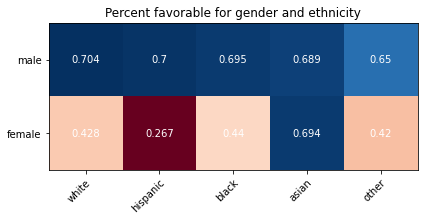

In [12]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

percent_favorable = df_bias['Binary Outcome'].mean()
# create an array of the mean of the binary outcome for each Gender and Ethnicity combination
gender_ethnicity_percent_favorable = []
for gender in GENDER:
    gender_row = []
    for ethnicity in ETHNICITY:
        df_demo = df_bias.loc[(df_bias['Demo Gender'] == gender) & (df_bias['Demo Ethnicity'] == ethnicity)]
        gender_row.append(df_demo['Binary Outcome'].mean())
    gender_ethnicity_percent_favorable.append(gender_row)

gender_ethnicity_percent_favorable = np.round(np.array(gender_ethnicity_percent_favorable),3)


# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(gender_ethnicity_percent_favorable)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(ETHNICITY)), labels=ETHNICITY)
ax.set_yticks(np.arange(len(GENDER)), labels=GENDER)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.rcParams['image.cmap'] = 'RdBu'

# Loop over data dimensions and create text annotations.
for i in range(len(GENDER)):
    for j in range(len(ETHNICITY)):
        text = ax.text(j, i, gender_ethnicity_percent_favorable[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Percent favorable for gender and ethnicity")
fig.tight_layout()
plt.show()

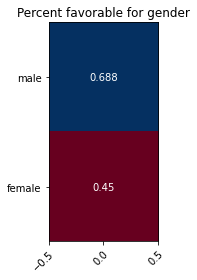

In [13]:
# gender plot
gender_percent_favorable = np.round(np.mean(np.array(gender_ethnicity_percent_favorable), axis=1),3)
gender_percent_favorable = np.resize(gender_percent_favorable, (2,1))

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(gender_percent_favorable)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(GENDER)), labels=GENDER)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.rcParams['image.cmap'] = 'RdBu'


# Loop over data dimensions and create text annotations.
for i in range(len(GENDER)):
    for j in [0]:
        text = ax.text(j, i, gender_percent_favorable[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Percent favorable for gender")
fig.tight_layout()
plt.show()

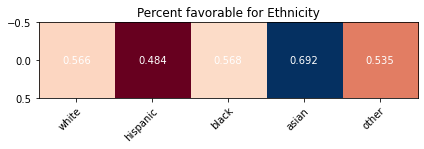

In [14]:
# ethnicity plot
ethnicity_percent_favorable = np.round(np.mean(np.array(gender_ethnicity_percent_favorable), axis=0),3)
ethnicity_percent_favorable = np.resize(ethnicity_percent_favorable, (1, len(ETHNICITY)))

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(ethnicity_percent_favorable)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(ETHNICITY)), labels=ETHNICITY)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.rcParams['image.cmap'] = 'RdBu'


# Loop over data dimensions and create text annotations.
for i in [0]:
    for j in range(len(ETHNICITY)):
        text = ax.text(j, i, ethnicity_percent_favorable[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Percent favorable for Ethnicity")
fig.tight_layout()
plt.show()

In [ ]:
# ethnicity plot
ethnicity_perent_favorable = np.round(np.mean(np.array(gender_ethnicity_perent_favorable), axis=0),3)
ethnicity_perent_favorable = np.resize(ethnicity_perent_favorable, (1, len(ETHNICITY)))

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(ethnicity_perent_favorable)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(ETHNICITY)), labels=ETHNICITY)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in [0]:
    for j in range(len(ETHNICITY)):
        text = ax.text(j, i, ethnicity_perent_favorable[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Percent favorable for Ethnicity")
fig.tight_layout()
plt.show()

### Single score for the model
Percent (ratio) of positive outcomes for the privileged group (white, male) vs the rest of the population as the `disparate impact ratio`. In this case, the disparate impact ratio we use compares the percentage of favorable outcomes for the protected classes (all non-white-males) to the percentage of favorable outcomes for the non protected class (white, male). Ideally the ratio equals 1 for an unbiased model. A ratio higher than 1 performs worse on the non-protected classes and a ratio lower than 1 is traditionally biased favoring positive outcomes for the non-protected class.

In [ ]:
white_male = df_bias.loc[(df_bias['Demo Ethnicity'] == 'white') & (df_bias['Demo Gender'] == 'male')]
# get all indexes not in dataframe df_bias that are not in dataframe white_male
non_white_male = df_bias[~df_bias.index.isin(white_male.index)]

prev_fav = np.mean(white_male['Binary Outcome'])
protected_fav = np.mean(non_white_male['Binary Outcome'])

disparate_impact_ratio = protected_fav / prev_fav